In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Funciones auxiliares 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_outliers(serie, fechas=None, outliers=None):
    '''Graficar la Serie de Tiempo y superponer "outliers" de
    referencia y detectados.
    
    Parámetros:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    - fechas: listado de fechas con los "outliers" conocidos
    - outliers: los outliers detectados (DataFrame de Pandas)'''
    
    # Graficar la Serie de tiempo
    ax = serie.plot(alpha=0.7)
    
    # Validar si hay fechas de outliers
    if fechas is not None and len(fechas) > 0:
        # Superponer outliers de referencia
        serie.loc[fechas].plot(ax=ax, style='bo')
    
    # Validar si hay outliers detectados
    if outliers is not None and not outliers.empty:
        outliers.plot(ax=ax, style='rx')
        plt.legend(['Serie de Tiempo', 'Outliers conocidos', 'Outliers detectados'])
    else:
        if fechas is not None and len(fechas) > 0:
            plt.legend(['Serie de Tiempo', 'Outliers conocidos'])
        else:
            plt.legend(['Serie de Tiempo'])
    
    # Ajustar etiquetas    
    plt.xlabel('Fecha')
    plt.ylabel('kwh')




In [9]:
def outliers_tukey(serie):
    '''Detecta los "outliers" en la Serie de Tiempo usando
    el método de Tukey.
    
    Entradas:
    - serie: la Serie de Tiempo (DataFrame de Pandas)
    
    Salida:
    - outliers: DataFrame de Pandas con los valores extremos detectados
    '''
    
    # 1. Calcular Q1 y Q3
    q1, q3 = np.percentile(serie, [25, 75])
    
    # 2. Calcular IQR
    IQR = q3 - q1
    
    # 3. Calcular límites superior e inferior
    lim_sup = q3 + 1.5*IQR
    lim_inf = q1 - 1.5*IQR
    
    # 4. Filtrar serie de tiempo para detectar los outliers
    outliers = serie[(serie.to_numpy() > lim_sup) | (serie.to_numpy() < lim_inf)]
    
    return outliers

## **Análisis Exploratorio de la Serie de Tiempo**

La idea básica del Análisis Exploratorio es entender el comportamiento de la Serie de Tiempo usando diferentes herramientas (estadística descriptiva, herramientas gráficas y **creatividad**, entre otras).

La idea es que en cada fase del análisis se escriban unas breves observaciones que al final se resumirán.

Y el análisis exploratorio siempre debe estar guiado por una pregunta que queramos resolver. Es decir que todo lo que hagamos durante el análisis debe estar orientado a responder esa pregunta.

Planteemos esta pregunta general:

. ¿Cómo varía el consumo energético a lo largo del tiempo?

In [10]:
building_2a=pd.read_csv(data_dir("interim","2A_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [11]:
building_2a.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,0.0
2023-01-01 00:15:00+00:00,0.0
2023-01-01 00:30:00+00:00,0.0
2023-01-01 00:45:00+00:00,0.0
2023-01-01 01:00:00+00:00,0.0


In [12]:
building_2a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2023-01-01 00:00:00+00:00 to 2023-12-31 23:45:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kwh     35040 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB


Text(0, 0.5, 'Consumo de energía (kWh)')

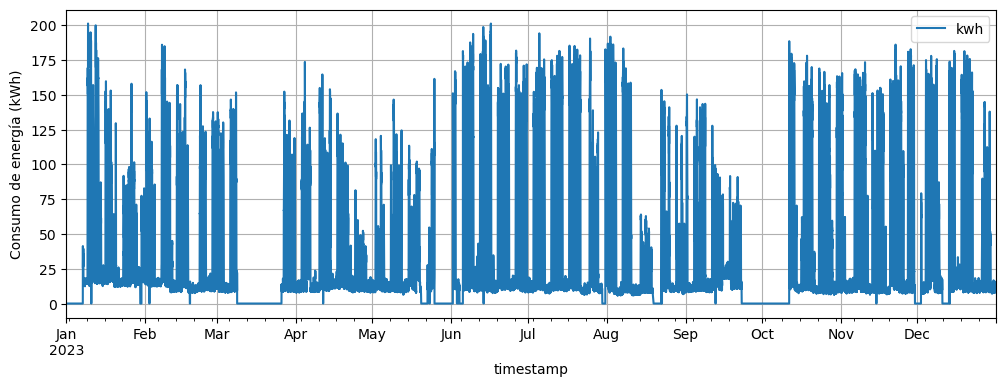

In [14]:
ax = building_2a.plot(figsize=(12,4))
ax.grid()
ax.set_ylabel("Consumo de energía (kWh)")

Y a partir de este sencillo gráfico ya podemos realizar algunas observaciones:

- La serie posiblemente no tiene una **tendencia** 
- se observan posibles patrones estacionales 

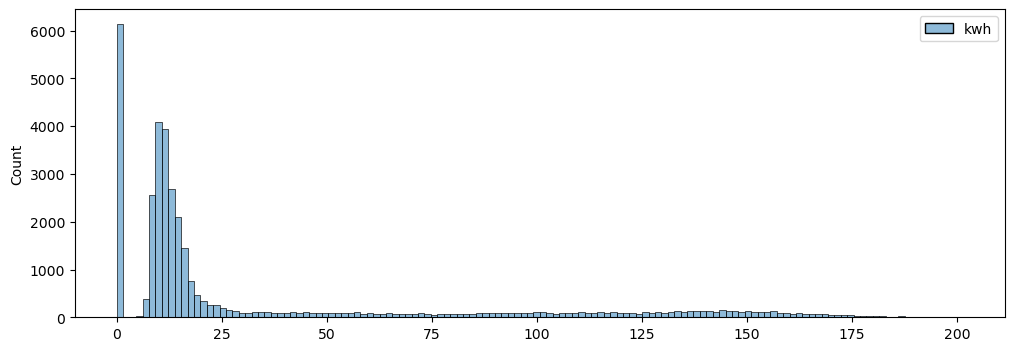

In [15]:
plt.figure(figsize=(12, 4))

# Observamos la distribución de los datos
ax = sns.histplot(data=building_2a)

1. **Pico en 0 kWh:** 
   Hay un gran número de datos que caen en el valor de **0 kWh**, Es importante investigar si estos valores de cero son reales o si son valores faltantes que se imputaron de esta manera.

2. **Sesgo en los valores bajos (entre 0 y 50 kWh):**
   La mayor parte de los datos se concentra en un rango bajo de consumo, lo que sugiere que el consumo de energía es generalmente bajo o que la mayoría de las observaciones corresponden a períodos sin consumo significativo.

3. **Cola larga en el lado derecho (valores más altos):**
   Hay una larga cola en la parte derecha del gráfico, que indica que existen valores atípicos o eventos de consumo energético mucho más altos (superiores a 100 kWh). Estos eventos pueden ser anómalos, eventos de alta demanda o picos inusuales de consumo, que podrían requerir un análisis adicional para determinar si son errores o comportamientos reales.

4. **Posible sesgo en la distribución:**
   La distribución no es simétrica, sino que está sesgada hacia la izquierda.


deteccion de outliers

El problema en este caso es que tenemos demasiados datos (35040) y por más que ajustemos la escala temporal y el tamaño de la gráfica, resulta difícil tener una visualización adecuada de la serie de tiempo.

Una alternativa es **remuestrear** la Serie de Tiempo para preservar la información relevante pero a la vez tener menos datos.

                           kwh
timestamp                     
2023-01-01 00:00:00+00:00  0.0
2023-01-01 01:00:00+00:00  0.0
2023-01-01 02:00:00+00:00  0.0
2023-01-01 03:00:00+00:00  0.0
2023-01-01 04:00:00+00:00  0.0


Text(0, 0.5, 'Promedio Consumo de energía  por dia (kWh)')

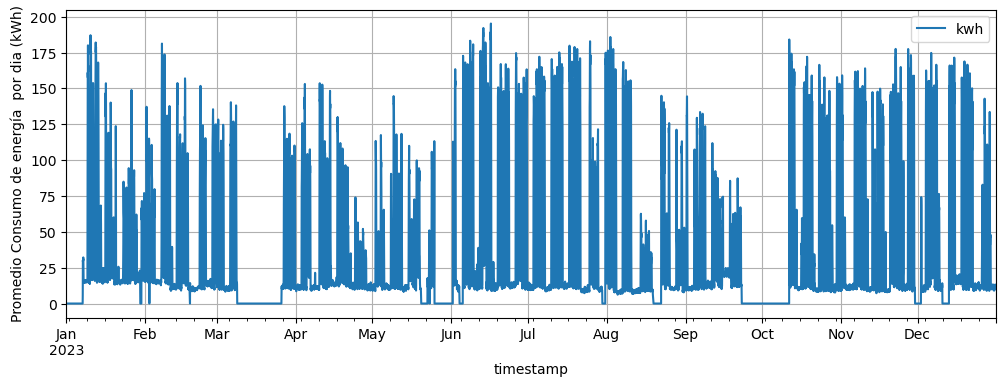

In [19]:
# Remuestreo a frecuencia diaria
building_2a_hora = building_2a.resample('h').mean()
print(building_2a_hora.head())
ax = building_2a_hora.plot(figsize=(12,4))
ax.grid()
ax.set_ylabel("Promedio Consumo de energía  por dia (kWh)")

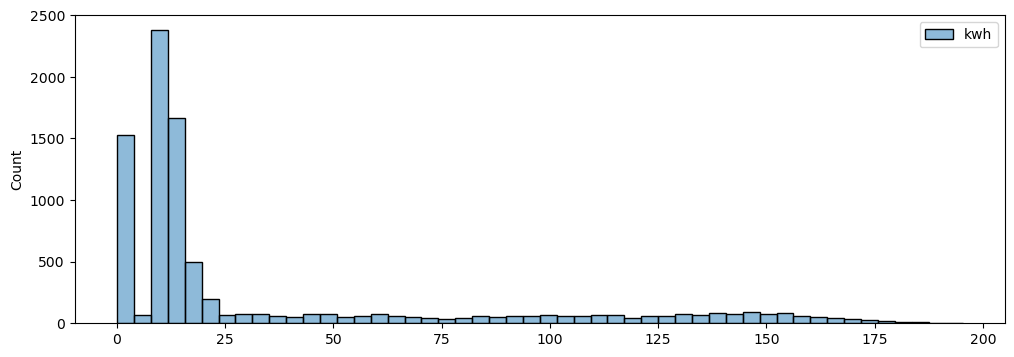

In [20]:
plt.figure(figsize=(12, 4))

# Observamos la distribución de los datos
ax = sns.histplot(data=building_2a_hora,bins=50)

                           kwh
timestamp                     
2023-01-01 00:00:00+00:00  0.0
2023-01-02 00:00:00+00:00  0.0
2023-01-03 00:00:00+00:00  0.0
2023-01-04 00:00:00+00:00  0.0
2023-01-05 00:00:00+00:00  0.0


Text(0, 0.5, 'Promedio Consumo de energía (kWh)')

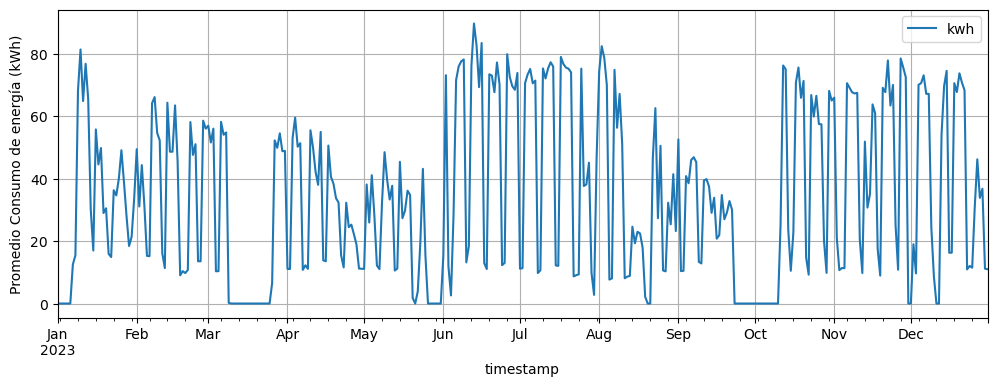

In [21]:
# Remuestreo a frecuencia diaria
building_2a_diaria = building_2a.resample('D').mean()
print(building_2a_diaria.head())
ax = building_2a_diaria.plot(figsize=(12,4))
ax.grid()
ax.set_ylabel("Promedio Consumo de energía (kWh)")

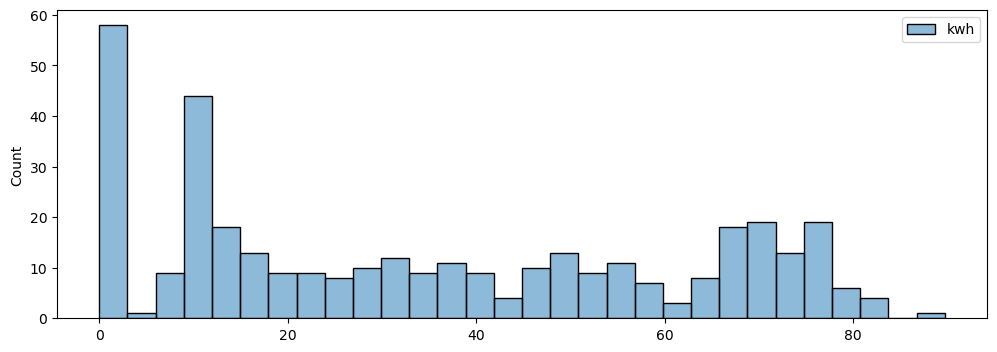

In [22]:
plt.figure(figsize=(12, 4))

# Observamos la distribución de los datos
ax = sns.histplot(data=building_2a_diaria,bins=30)

In [23]:
#building_2a_hourly = building_2a.resample('H').mean()
#building_2a_hourly.to_csv(data_dir("interim","11a_hourly.csv"))


Recordemos que la media es un valor sensible a valores extremos, así que al hacer el remuestreo con el promedio de los datos estamos intentanto garantizar que no se pierde la información relacionada con esos valores extremos.

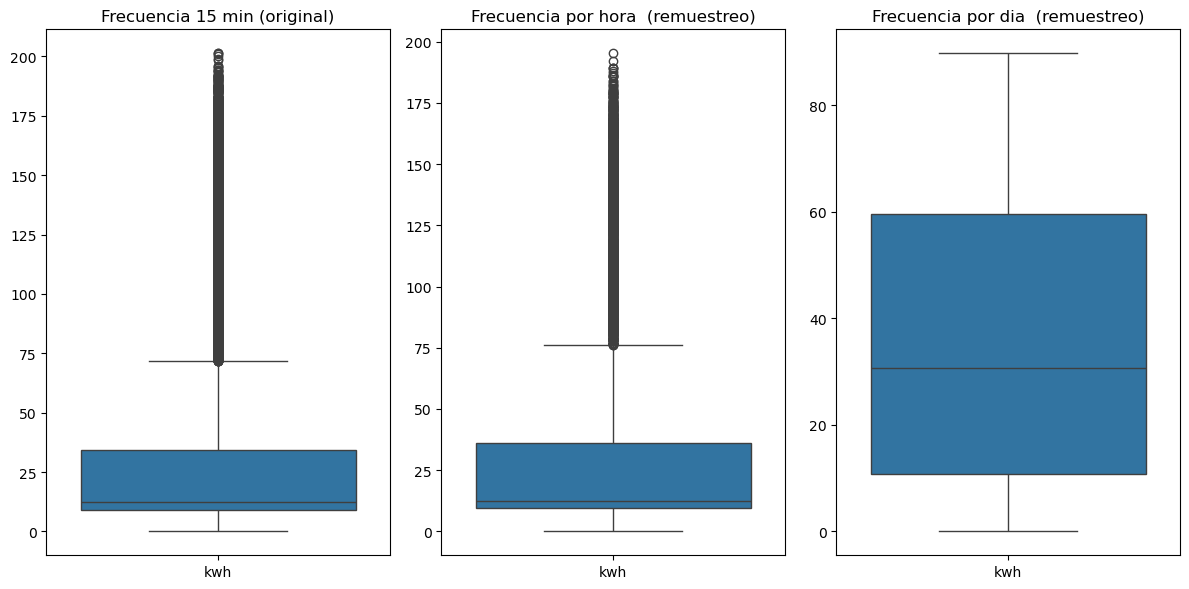

In [24]:
# Crear grilla de 1x3
fig, axs = plt.subplots(1,3, figsize=(12, 6))

# Boxplot 1 (serie de tiempo original)
sns.boxplot(building_2a, ax = axs[0])
axs[0].set_title('Frecuencia 15 min (original)')

# Boxplot 2 (serie de tiempo remuestreada por hora)
sns.boxplot(building_2a_hora, ax = axs[1])
axs[1].set_title('Frecuencia por hora  (remuestreo)')

# Boxplot 3 (serie de tiempo remuestreada por dia)
sns.boxplot(building_2a_diaria, ax = axs[2])
axs[2].set_title('Frecuencia por dia  (remuestreo)')


fig.tight_layout()


Al analizar visualmente los boxplots de la serie original y de la serie remuestreada a la media por hora, se identifican valores atípicos (outliers) que reflejan fluctuaciones de corto plazo o eventos aislados en el consumo. Sin embargo, al remuestrear los datos utilizando la media diaria, estas anomalías desaparecen casi por completo, proporcionando una visión más estable y representativa del comportamiento energético a nivel diario.
aplicamos el metodo de tuckey para deteccion de outliers ya que este metodo no depende de la distribucion de los datos

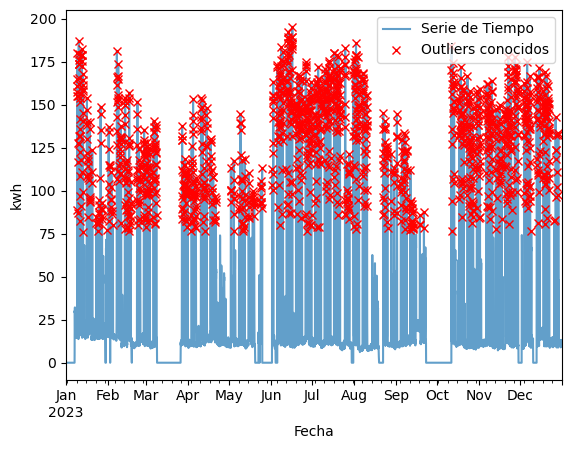

In [25]:
outliers=outliers_tukey(building_2a_hora)
graficar_outliers(building_2a_hora,outliers=outliers)

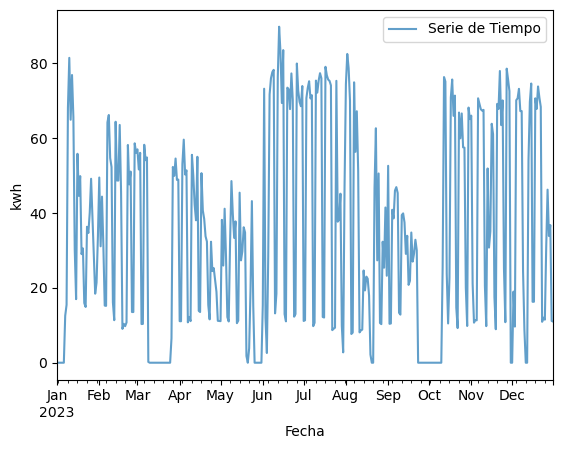

In [26]:
outliers=outliers_tukey(building_2a_diaria)
graficar_outliers(building_2a_diaria,outliers=outliers)

Basándonos en el remuestreo diario de la serie de tiempo y en la evaluación de los datos mediante gráficos de boxplot y la detección de outliers utilizando el método de Tukey, podemos concluir que no se observan outliers evidentes en la gráfica. 

Analisis de autocorrelacion

procedemos a realizar un analisis de autocorrelacion de la serie de tiempo para identificar posibles tendencias o estacionalidad 

In [27]:
import statsmodels.graphics.tsaplots as tsaplots

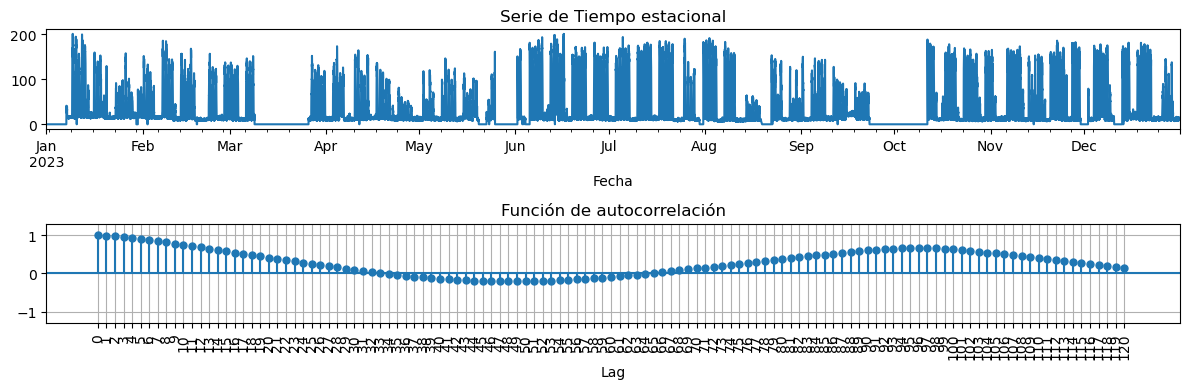

In [28]:
# Gráfico serie estacional
fig, ax = plt.subplots(2,1, figsize=(12,4))

# Serie de tiempo
building_2a['kwh'].plot(ax=ax[0])
ax[0].set_xlabel('Fecha')
ax[0].set_title('Serie de Tiempo estacional')

# Gráfico función de autocorrelación
LAGS = 120
tsaplots.plot_acf(building_2a['kwh'].to_numpy(), 
                  adjusted=True, 
                  alpha=0.05, # Intervalo de confianza del 95%
                  lags = LAGS, ax = ax[1], bartlett_confint = False);
ax[1].set_xlabel('Lag')
ax[1].set_xticks(range(0,LAGS+1))
ax[1].set_title('Función de autocorrelación')
ax[1].set_ylim([-1.3,1.3])
ax[1].grid()
plt.xticks(rotation=90)
fig.tight_layout()

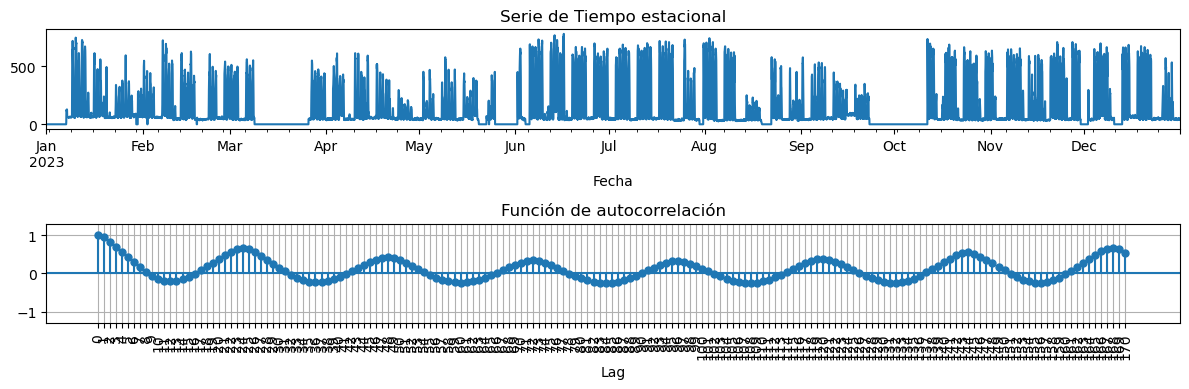

In [29]:
building_2a_hora_sum = building_2a.resample('h').sum()

# Gráfico serie estacional
fig, ax = plt.subplots(2,1, figsize=(12,4))

# Serie de tiempo
building_2a_hora_sum['kwh'].plot(ax=ax[0])
ax[0].set_xlabel('Fecha')
ax[0].set_title('Serie de Tiempo estacional')

# Gráfico función de autocorrelación
LAGS =170
tsaplots.plot_acf(building_2a_hora_sum['kwh'].to_numpy(), 
                  adjusted=True, 
                  alpha=0.05, # Intervalo de confianza del 95%
                  lags = LAGS, ax = ax[1], bartlett_confint = False);
ax[1].set_xlabel('Lag')
ax[1].set_xticks(range(0,LAGS+1))
ax[1].set_title('Función de autocorrelación')
ax[1].set_ylim([-1.3,1.3])
ax[1].grid()
plt.xticks(rotation=90)

fig.tight_layout()

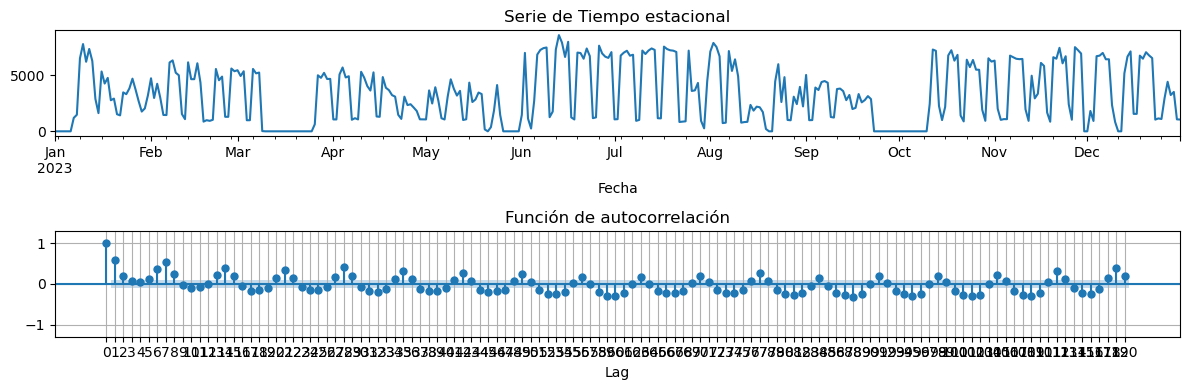

In [30]:
building_2a_diaria_sum = building_2a.resample('D').sum()

# Gráfico serie estacional
fig, ax = plt.subplots(2,1, figsize=(12,4))

# Serie de tiempo
building_2a_diaria_sum['kwh'].plot(ax=ax[0])
ax[0].set_xlabel('Fecha')
ax[0].set_title('Serie de Tiempo estacional')

# Gráfico función de autocorrelación
LAGS = 120
tsaplots.plot_acf(building_2a_diaria_sum['kwh'].to_numpy(), 
                  adjusted=True, 
                  alpha=0.05, # Intervalo de confianza del 95%
                  lags = LAGS, ax = ax[1], bartlett_confint = False);
ax[1].set_xlabel('Lag')
ax[1].set_xticks(range(0,LAGS+1))
ax[1].set_title('Función de autocorrelación')
ax[1].set_ylim([-1.3,1.3])
ax[1].grid()
fig.tight_layout()

Analisis de componentes

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

Residual desc. aditiva: -0.0015
Residual desc. STL:     0.0822


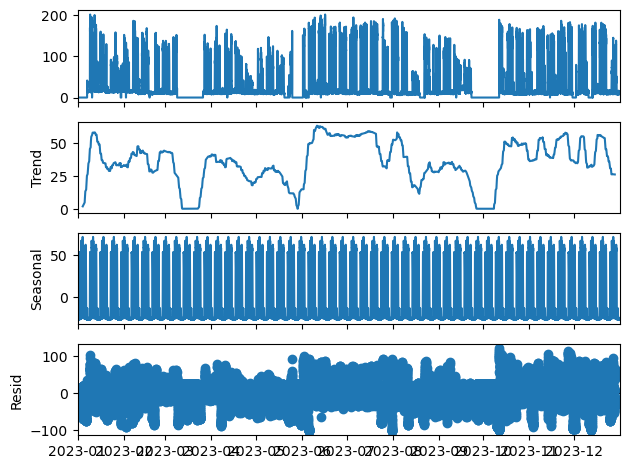

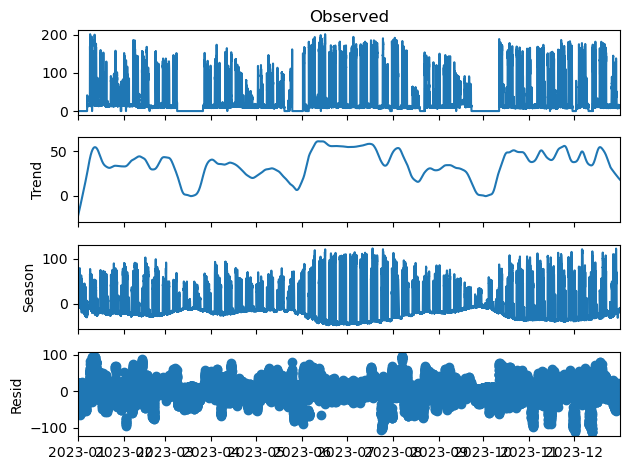

In [32]:
periodo=672
# Descomposiciones básicas pasajeros
pas_dec_add = seasonal_decompose(building_2a,model='additive',period=periodo)
#pas_dec_mul = seasonal_decompose(building_2a_hora_sum,model='multiplicative',period=periodo)
# Descomposición STL pasajeros
pas_stl = STL(building_2a,period=periodo).fit()


# Gráficas
pas_dec_add.plot();
#pas_dec_mul.plot();
# Graficar
pas_stl.plot();

# Comparar residuales
print(f'Residual desc. aditiva: {pas_dec_add.resid.mean():.4f}')
print(f'Residual desc. STL:     {pas_stl.resid.mean():.4f}')

Residual desc. aditiva: -2.9790
Residual desc. STL:     9.2015


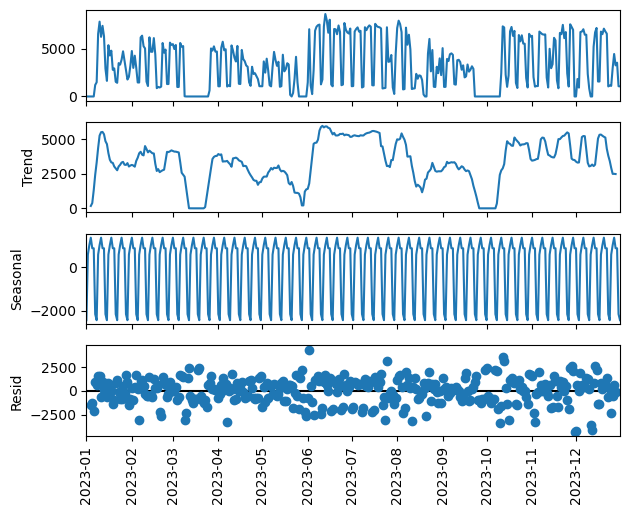

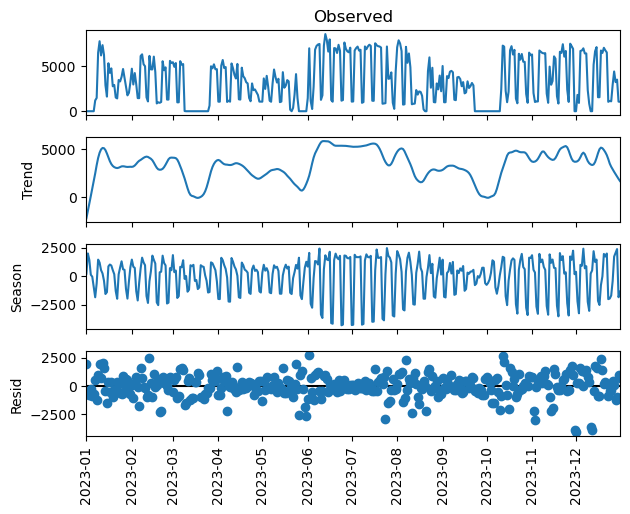

In [34]:
building_2a_diaria_sum = building_2a.resample('D').sum()
periodo=7
# Descomposiciones básicas pasajeros
pas_dec_add = seasonal_decompose(building_2a_diaria_sum,model='additive')
#pas_dec_mul = seasonal_decompose(building_2a_hora_sum,model='multiplicative',period=periodo)
# Descomposición STL pasajeros
pas_stl = STL(building_2a_diaria_sum).fit()


# Gráficas
pas_dec_add.plot();
plt.xticks(rotation=90);
#pas_dec_mul.plot();
# Graficar
pas_stl.plot();
plt.xticks(rotation=90);
# Comparar residuales
print(f'Residual desc. aditiva: {pas_dec_add.resid.mean():.4f}')
print(f'Residual desc. STL:     {pas_stl.resid.mean():.4f}')

Gráficos estacionales

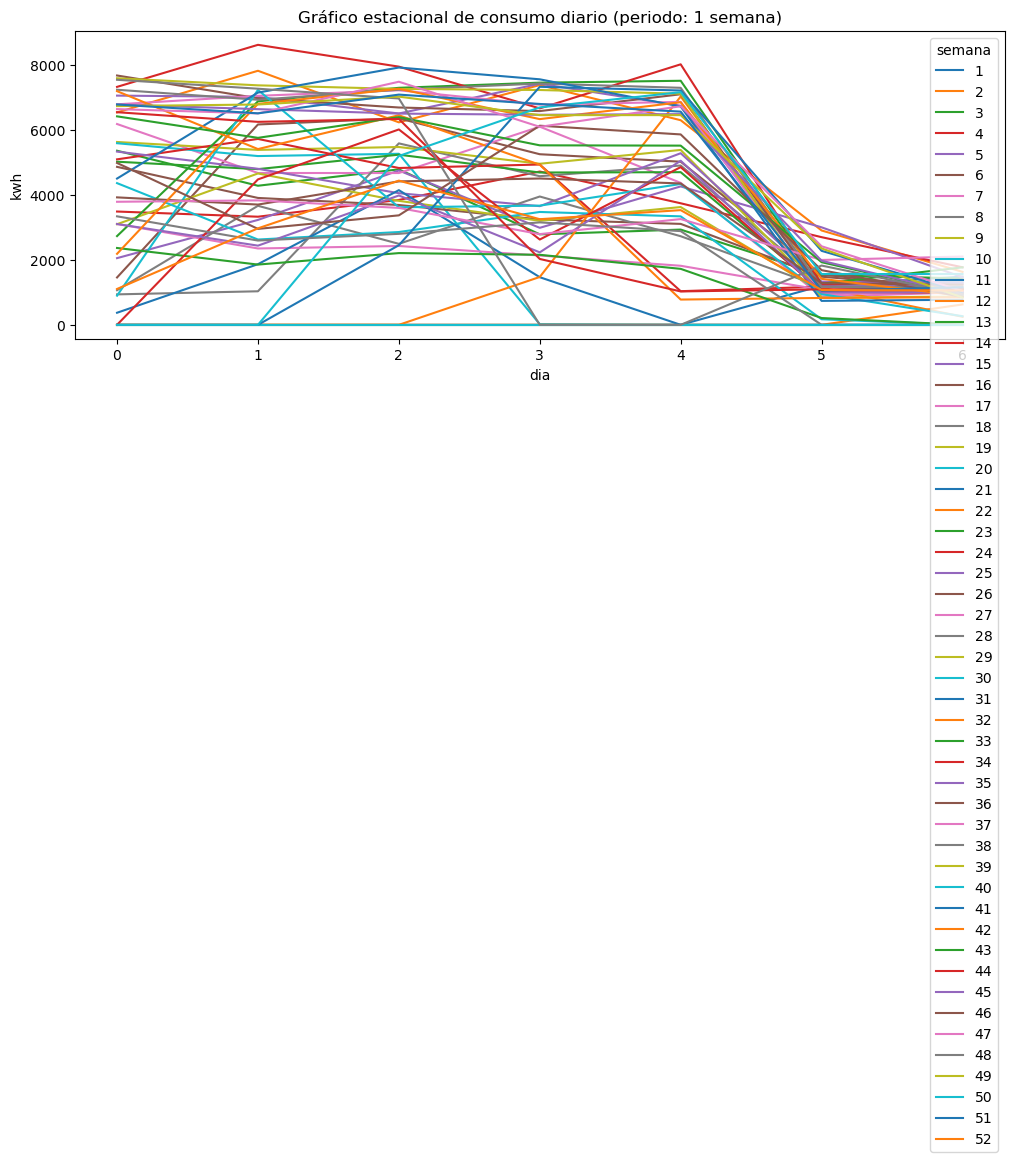

In [35]:
building_2a_diaria_sum["weekday"] =building_2a_diaria_sum.index.weekday
building_2a_diaria_sum['semana'] = building_2a_diaria_sum.index.isocalendar().week
# Por cada año graficar el comportamiento mes a mes
building_2a_diaria_sum_pivot = building_2a_diaria_sum[1:].pivot(index='weekday', columns='semana', values="kwh")
building_2a_diaria_sum_pivot.plot(figsize=(12,4))
plt.title('Gráfico estacional de consumo diario (periodo: 1 semana)')
plt.xlabel('dia')
plt.ylabel('kwh')
plt.legend(title='semana');

In [36]:
building_2a_seas=pas_stl.seasonal.to_frame("kwh")
building_2a_seas.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,222.697447
2023-01-02 00:00:00+00:00,1991.739020
2023-01-03 00:00:00+00:00,1417.599829
2023-01-04 00:00:00+00:00,129.103581
2023-01-05 00:00:00+00:00,-42.112392


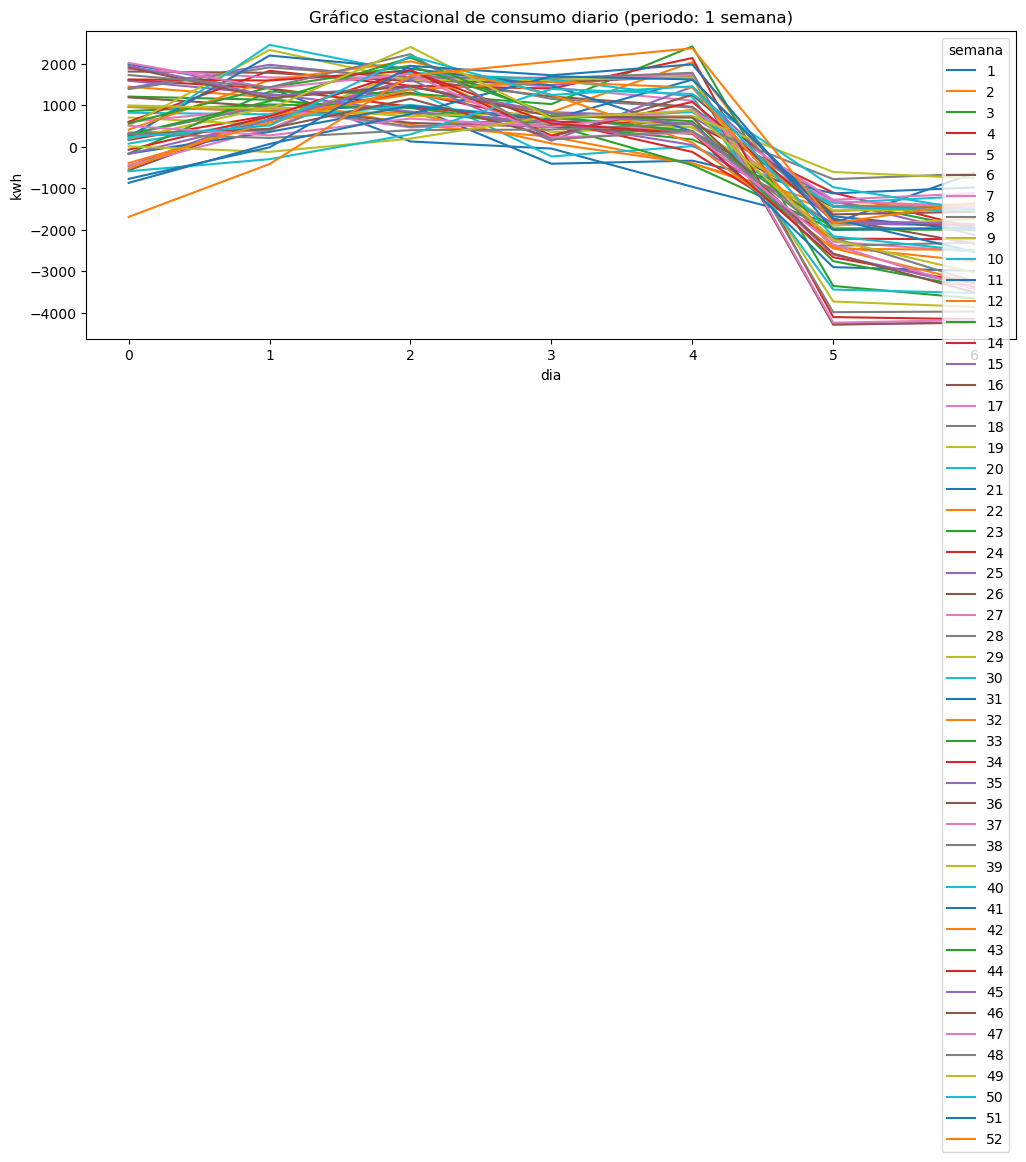

In [37]:
# Remuestreo mensual
building_2a_sd = building_2a_seas.resample('D').sum()

# Agregar columnas "mes" y "año"
building_2a_sd["weekday"] =building_2a_sd.index.weekday
building_2a_sd['semana'] = building_2a_sd.index.isocalendar().week

# Tabla pivote
building_2a_sd_pivot = building_2a_sd[1:].pivot(index='weekday', columns='semana', values="kwh")

# Gráfico
building_2a_sd_pivot.plot(figsize=(12,4))
plt.title('Gráfico estacional de consumo diario (periodo: 1 semana)')
plt.xlabel('dia')
plt.ylabel('kwh')
plt.legend(title='semana');

Prueba de estacionaridad

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
def verificar_estacionariedad(serie):
    # Realizar prueba
    adf = adfuller(serie)
    
    # Extraer el valor de p    
    p = adf[1]
    
    if p < 0.05:
        # Se rechaza la hipótesis nula: la serie es estacionaria
        print(f'La serie es estacionaria porque p = {p:.2f} < 0.05')
    else:
        # Se acepta la hipótesis nula: la serie es NO estacionaria
        print(f'La serie NO es estacionaria porque p = {p:.2f} >= 0.05')

In [40]:
verificar_estacionariedad(building_2a)

La serie es estacionaria porque p = 0.00 < 0.05
